# Jan 27th, 2022 (SE debug)

**Motivation**: Why such large standard error for animals but not for the group?  <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


def plot_df_se(df, title=None, bbox_to_anchor=(1.07, 0.55)):
    fg = sns.catplot(
        data=df,
        x='oc_idx',
        y='SE',
        hue='label',
        col='bin_idx',
        col_wrap=2,
        kind='point',
        height=3.5,
        ci=None,
    )
    for ax in fg.axes.flat:
        ax.grid(ls=':')
        ax.set_title(ax.get_title(), fontsize=13)
        ax.set_xlabel(ax.xaxis.get_label().get_text(), fontsize=13)
        ax.set_ylabel(ax.yaxis.get_label().get_text(), fontsize=13)

    plt.setp(fg.legend, bbox_to_anchor=bbox_to_anchor)
    for text in fg.legend.get_texts():
        plt.setp(text, fontsize=14)
    fg.legend.set_title(title)
    plt.setp(fg.legend.get_title(), fontsize=15)
    plt.show()
    
    return fg

## Prepare

In [3]:
mice = Mice((128, 0, 100))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

In [4]:
props_base = {
    'num_k': 5,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'perc': 'p20-sample', **props_base}
props_bold = {'perc': 'p20-sample', **props_base}

gr_ca = Group(mode='ca2', centroids_from='runs', **props_ca).fit_group(skip_align=False)
gr_bold = Group(mode='bold-lite', centroids_from='runs', **props_bold).fit_group(skip_align=False)

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi,
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

proj_bold = gr_bold.project_vec()
proj_ca = gr_ca.project_vec()

## Membership plot

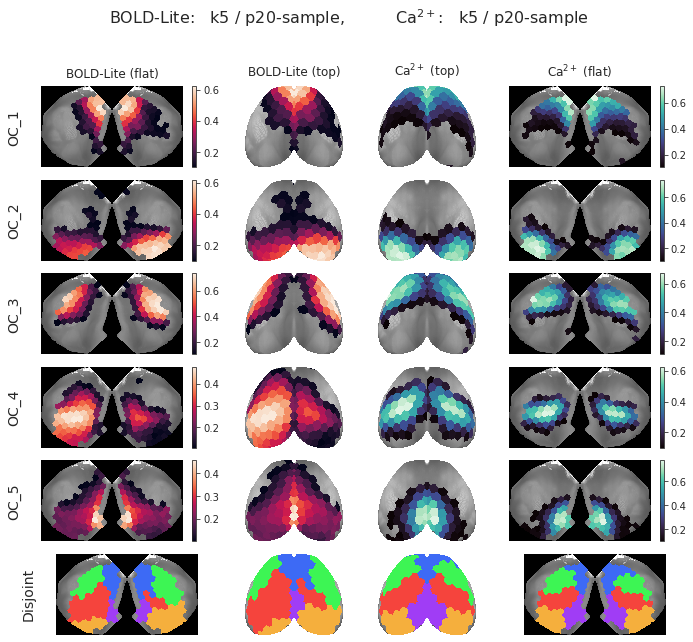

In [5]:
fig, _ = gr_ca.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'Ca$^{2+}$'),
    cmaps=('rocket', 'mako'),
    display=False,
)
sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

## Proportions (group)

In [6]:
# Load SciPy boot
boot_bca = 'boot-BCa_group_1.0e+03_(2022_01_26).npy'
boot_bca = np.load(pjoin(tmp_dir, boot_bca), allow_pickle=True)
boot_bca = boot_bca.item()

# Load full boot
boot_gam = 'boot-GAM_group_1.0e+03_(2022_01_26).npy'
boot_gam = np.load(pjoin(tmp_dir, boot_gam), allow_pickle=True)
boot_gam = boot_gam.item()

# Prepare gam booted
_stat = mk_statistic_fn(gr_bold.bins, est_seed=None)

output_booted_ca = _stat(boot_gam['ca2'])
output_booted_bold = _stat(boot_gam['bold-lite'])

In [7]:
mu_real = gr_ca.grp_cut
mu_boot = output_booted_ca['cut_avg'].mean(0)
delta_mu_ca = (mu_real - mu_boot) / mu_real
delta_mu_ca *= 100

mu_real = gr_bold.grp_cut
mu_boot = output_booted_bold['cut_avg'].mean(0)
delta_mu_bold = (mu_real - mu_boot) / mu_real
delta_mu_bold *= 100

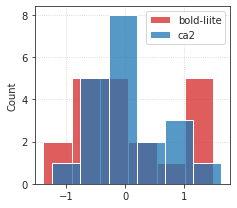

In [8]:
fig, ax = create_figure(figsize=(3.4, 3))
sns.histplot(delta_mu_bold.flat, color='C3', label='bold-liite', ax=ax)
sns.histplot(delta_mu_ca.flat, color='C0', label='ca2', ax=ax)
ax.legend()
ax.grid()
plt.show()

Fig: distribution of % difference between real mean and boostrapped mean.  We see that the mean of bootstrapped samples is very close to the actual means. Distribution is over communities and bins: $5 * 4 = 20$ numbers per modality.

In [9]:
df_se_ca = gr_ca.mk_se_df(
    se_bca=boot_bca['ca2']['se'],
    samples_boot=output_booted_ca['cut_avg'],
)
df_se_bold = gr_bold.mk_se_df(
    se_bca=boot_bca['bold-lite']['se'],
    samples_boot=output_booted_bold['cut_avg'],
)

### Definition of terms in plot legend:

#### boot_bca
This is the standed error (SE) calculated using SciPy's implementaion of bias-corrected and accelerated (BCa) bootstrap.

#### boot_std
This is SE estimated by calculating standard deviation of bootstrapped samples:

$$SE_B(\hat{\alpha}) = \sqrt{\frac{1}{B - 1}\sum_{r=1}^B \Big ( \hat{\alpha}^*_r - \sum_{r^\prime=1}^B \hat{\alpha}^*_{r^\prime} \Big)^2},$$
where $B = 1000$ is number of bootstrapped samples.

#### real_std
This is simply standard error of the mean estimated using the real sample:

$$SE_{real} \approx \frac{s}{\sqrt{n}},$$
where $s$ is sample standard deviation and $n$ is the number of samples.

### Number of samples
For the group average, we have $n = 10$ (subjects), and for each individual we have $n = 3$ (sessions).

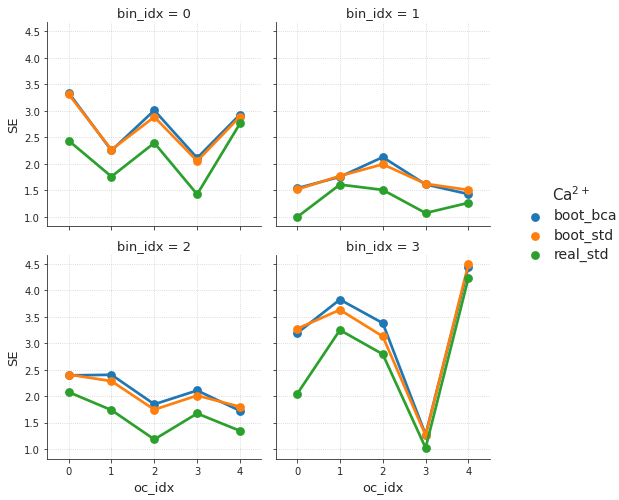

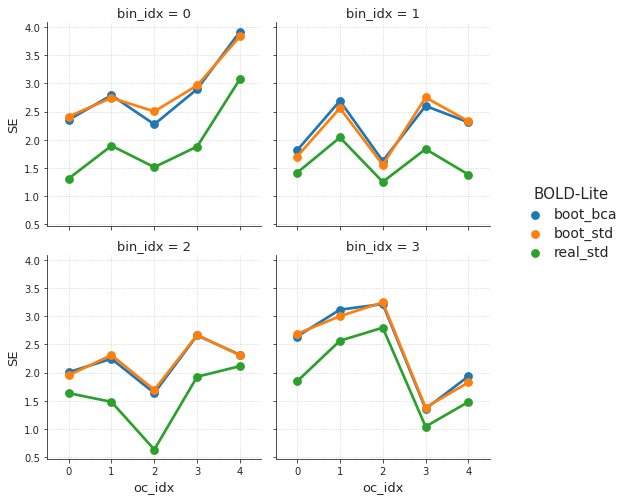

In [10]:
_ = plot_df_se(df_se_ca, r"Ca$^{2+}$")
_ = plot_df_se(df_se_bold, 'BOLD-Lite')

## Proportions (indiv)

In [11]:
# Load SciPy boot
boot_bca = 'boot-BCa_indiv_1.0e+03_(2022_01_26).npy'
boot_bca = np.load(pjoin(tmp_dir, boot_bca), allow_pickle=True)
boot_bca = boot_bca.item()

# Load full boot
boot_gam = 'boot-GAM_indiv_1.0e+03_(2022_01_26).npy'
boot_gam = np.load(pjoin(tmp_dir, boot_gam), allow_pickle=True)
boot_gam = boot_gam.item()

# Prepare gam booted
_stat = mk_statistic_fn(gr_bold.bins, est_seed=None)

output_booted_ca = _stat(boot_gam['ca2'])
output_booted_bold = _stat(boot_gam['bold-lite'])

In [12]:
def fun(x, est_seed=None):
    pi = pi_from_gam(x, axis_comm=-2, axis_seed=-3, est_seed=est_seed)
    k, n = pi.shape[-2:]
    cut, _ = cut_data(
        data=pi.reshape(-1, k, n),
        bins=gr_ca.bins,
        oc_only=True,
    )
    cut = cut.reshape((*pi.shape[:-2], k, -1))
    return bn.nanmean(cut, -3)

### sub-SLC04 (anim = 3)

In [13]:
anim = 3

In [14]:
samples_real = fun(gr_ca.run_gam[anim], est_seed=bn.nanmean)
samples_boot = fun(boot_gam['ca2'][:, anim, ...], est_seed=None)
samples_boot = bn.nanmean(samples_boot, 1)

mu_real = bn.nanmean(samples_real, 0)
mu_boot = bn.nanmean(samples_boot, 0)
delta_mu_ca = (mu_real - mu_boot) / mu_real
delta_mu_ca *= 100

df_se_ca = gr_ca.mk_se_df(
    se_bca=boot_bca['ca2']['se'][anim],
    samples_boot=samples_boot,
    samples_real=samples_real,
)


samples_real = fun(gr_bold.run_gam[anim], est_seed=bn.nanmean)
samples_boot = fun(boot_gam['bold-lite'][:, anim, ...], est_seed=None)
samples_boot = bn.nanmean(samples_boot, 1)

mu_real = bn.nanmean(samples_real, 0)
mu_boot = bn.nanmean(samples_boot, 0)
delta_mu_bold = (mu_real - mu_boot) / mu_real
delta_mu_bold *= 100

df_se_bold = gr_bold.mk_se_df(
    se_bca=boot_bca['bold-lite']['se'][anim],
    samples_boot=samples_boot,
    samples_real=samples_real,
)

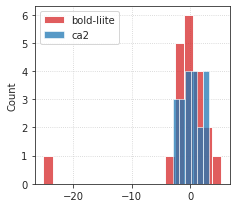

In [15]:
fig, ax = create_figure(figsize=(3.4, 3))
sns.histplot(delta_mu_bold.flat, color='C3', label='bold-liite', ax=ax)
sns.histplot(delta_mu_ca.flat, color='C0', label='ca2', ax=ax)
ax.legend()
ax.grid()
plt.show()

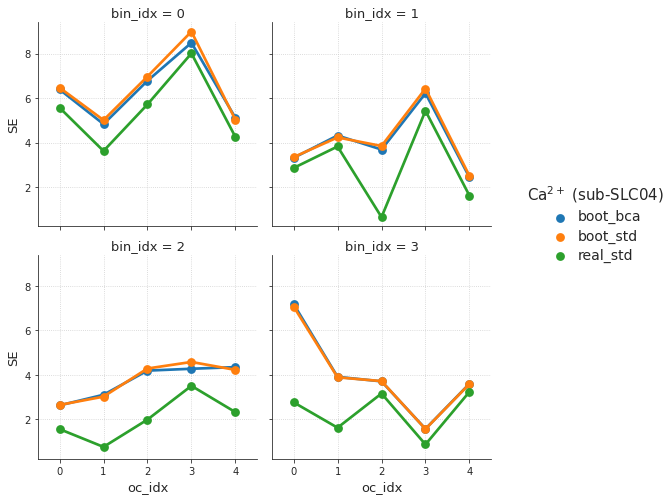

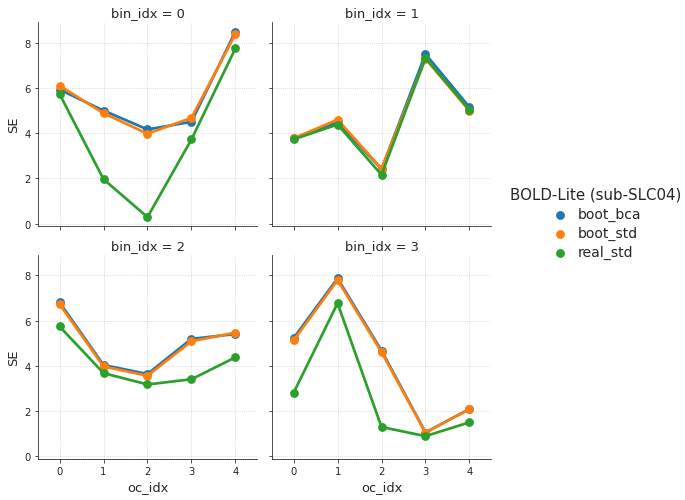

In [16]:
_ = plot_df_se(df_se_ca, r"Ca$^{2+}$" + f" (sub-SLC{anim + 1:02d})", (1.15, 0.55))
_ = plot_df_se(df_se_bold, 'BOLD-Lite' + f" (sub-SLC{anim + 1:02d})", (1.18, 0.55))

### All animals

In [ ]:
for anim in range(10):
    samples_real = fun(gr_ca.run_gam[anim], est_seed=bn.nanmean)
    samples_boot = fun(boot_gam['ca2'][:, anim, ...], est_seed=None)
    samples_boot = bn.nanmean(samples_boot, 1)

    mu_real = bn.nanmean(samples_real, 0)
    mu_boot = bn.nanmean(samples_boot, 0)
    delta_mu_ca = (mu_real - mu_boot) / mu_real
    delta_mu_ca *= 100

    df_se_ca = gr_ca.mk_se_df(
        se_bca=boot_bca['ca2']['se'][anim],
        samples_boot=samples_boot,
        samples_real=samples_real,
    )


    samples_real = fun(gr_bold.run_gam[anim], est_seed=bn.nanmean)
    samples_boot = fun(boot_gam['bold-lite'][:, anim, ...], est_seed=None)
    samples_boot = bn.nanmean(samples_boot, 1)

    mu_real = bn.nanmean(samples_real, 0)
    mu_boot = bn.nanmean(samples_boot, 0)
    delta_mu_bold = (mu_real - mu_boot) / mu_real
    delta_mu_bold *= 100

    df_se_bold = gr_bold.mk_se_df(
        se_bca=boot_bca['bold-lite']['se'][anim],
        samples_boot=samples_boot,
        samples_real=samples_real,
    )
    
    fig, ax = create_figure(figsize=(3.4, 3))
    sns.histplot(delta_mu_bold.flat, color='C3', ax=ax)
    sns.histplot(delta_mu_ca.flat, color='C0', ax=ax)
    ax.grid()
    plt.show()

    _ = plot_df_se(df_se_ca, r"Ca$^{2+}$" + f" (sub-SLC{anim + 1:02d})", (1.15, 0.55))
    _ = plot_df_se(df_se_bold, 'BOLD-Lite' + f" (sub-SLC{anim + 1:02d})", (1.18, 0.55))
    
    print('-' * 80)
    print('-' * 80)
    print('\n\n')

## Run boot temp

In [ ]:
%%time

n_resamples = 1000 * 3

boot_bca, boot_gam = boot_group(
    gam_dict={
        gr_ca.mode: gr_ca.run_gam,
        gr_bold.mode: gr_bold.run_gam},
    n_resamples=n_resamples,
    bins=gr_bold.bins,
    save_dir=tmp_dir,
    indiv=True,
)
boot_bca, boot_gam = boot_group(
    gam_dict={
        gr_ca.mode: gr_ca.run_gam,
        gr_bold.mode: gr_bold.run_gam},
    n_resamples=n_resamples,
    bins=gr_bold.bins,
    save_dir=tmp_dir,
    indiv=False,
)